In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
import gc

from tqdm.notebook import tqdm
from scipy.stats import ttest_ind
from sklearn.utils import resample

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 300)

%matplotlib inline

/home/leohmelo/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/leohmelo/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/leohmelo/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/leohmelo/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [3]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, roc_curve

In [4]:
df_ton_iot_ddos = pd.read_csv('./datasets/NF-ToN-IoT-v2-DDoS.csv.gz', compression='gzip')
df_ton_iot_ddos.head()

,Unnamed: 0,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Attack,Label
0,1,192.168.1.193,49228,192.168.1.152,1880,6,0.0,1600,40,35741,65,24,16,24,4294952,15,15,128,128,1286,40,40,1286,1600.0,35741.0,0,0,0,0,800000,17864000,47,3,30,19,6,16425,237,0,0,0,0,0,0,Benign,0
1,2,192.168.1.152,0,192.168.1.193,0,1,0.0,212,2,0,0,0,0,0,0,0,0,64,64,106,106,0,106,212.0,NaN,0,0,0,0,1696000,0,2,0,0,0,0,0,0,771,3,0,0,0,0,Benign,0
2,3,192.168.1.169,65317,239.255.255.250,1900,17,0.0,165,1,0,0,0,0,0,0,0,0,0,0,165,165,0,165,165.0,NaN,0,0,0,0,1320000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Benign,0
3,4,192.168.1.79,60766,192.168.1.255,15600,17,0.0,63,1,0,0,0,0,0,0,0,0,0,0,63,63,0,63,63.0,NaN,0,0,0,0,504000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Benign,0
4,6,192.168.1.33,0,192.168.1.193,0,1,0.0,318,3,0,0,0,0,0,0,0,0,64,64,106,106,0,106,318.0,NaN,0,0,0,0,2544000,0,3,0,0,0,0,0,0,771,3,0,0,0,0,Benign,0


In [5]:
df_cic_ids_ddos = pd.read_csv('./datasets/NF-CSE-CIC-IDS2018-v2-DDoS.csv.gz', compression='gzip')
df_cic_ids_ddos.head()

,Unnamed: 0,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,1,213.202.230.143,29622,172.31.66.103,3389,6,0.0,1919,14,2031,11,223,219,30,0,0,0,101,101,1195,40,40,1195,1919.0,2031.0,0,0,0,0,15352000,16248000,17,6,0,1,1,8192,64000,0,0,0,0,0,0,0,Benign
1,2,172.31.66.5,65456,172.31.0.2,53,17,0.0,116,2,148,2,0,0,0,0,0,0,128,128,74,58,58,74,116.0,148.0,0,0,0,0,928000,1184000,4,0,0,0,0,0,0,0,0,2511,1,5,0,0,Benign
2,3,172.31.64.92,57918,172.31.0.2,53,17,0.0,70,1,130,1,0,0,0,0,0,0,0,0,130,70,70,130,70.0,130.0,0,0,0,0,560000,1040000,1,1,0,0,0,0,0,0,0,3371,1,60,0,0,Benign
3,4,18.219.32.43,63269,172.31.69.25,80,6,7.0,232,5,1136,4,223,222,27,4294827,140,0,127,127,1004,40,40,1004,232.0,1136.0,0,0,0,0,8000,9088000,8,0,0,1,0,8192,26883,0,0,0,0,0,0,1,DDoS attacks-LOIC-HTTP
4,5,172.31.65.93,51677,23.36.33.52,443,6,0.0,3988,41,3169,40,223,223,30,0,0,0,128,128,671,40,40,671,3988.0,3169.0,1148,28,0,0,31904000,25352000,73,1,3,4,0,8192,29200,31744,124,0,0,0,0,0,Benign


In [6]:
df_bot_iot_ddos = pd.read_csv('./datasets/NF-BoT-IoT-v2-DDoS.csv.gz', compression='gzip')
df_bot_iot_ddos.head()

,Unnamed: 0,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,3,192.168.100.147,52113,192.168.100.7,80,17,188.0,56,2,0,0,0,0,0,4294545,422,0,64,64,28,28,0,28,56.0,0.0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,DDoS
1,4,192.168.100.150,36780,192.168.100.6,80,17,188.0,56,2,0,0,0,0,0,4293732,1235,0,64,64,28,28,0,28,2828.0,0.0,0,0,0,0,224000,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,DDoS
2,5,192.168.100.148,61749,192.168.100.7,80,17,188.0,84,3,0,0,0,0,0,4293826,1141,0,64,64,28,28,0,28,2856.0,0.0,0,0,0,0,224000,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,DDoS
3,7,192.168.100.149,59453,192.168.100.6,80,17,188.0,56,2,0,0,0,0,0,4294502,465,0,64,64,28,28,0,28,56.0,0.0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,DDoS
4,10,192.168.100.148,29148,192.168.100.3,80,17,188.0,56,2,0,0,0,0,0,4293656,1311,0,64,64,28,28,0,28,2828.0,0.0,0,0,0,0,224000,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,DDoS


In [7]:
def preprocess(X):
    cols = X.select_dtypes(include=[np.float64]).columns
    X[cols] = X[cols].astype(np.float32)

    X.fillna(0, inplace=True)
    X.replace(np.inf, 9999, inplace=True)
    
    return X

In [8]:
remove_columns = ['Attack', 'IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO']

In [9]:
df_ton_iot_ddos.drop(remove_columns, axis=1, inplace=True)
df_cic_ids_ddos.drop(remove_columns, axis=1, inplace=True)
df_bot_iot_ddos.drop(remove_columns, axis=1, inplace=True)

In [10]:
df_ton_iot_ddos['Label'].value_counts()

0    6099469
1    2026234
Name: Label, dtype: int64

In [11]:
df_cic_ids_ddos['Label'].value_counts()

0    16635567
1     1390270
Name: Label, dtype: int64

In [12]:
df_bot_iot_ddos['Label'].value_counts()

1    18331847
0      135037
Name: Label, dtype: int64

In [13]:
seed=42

agents = {
    "agent1" : df_ton_iot_ddos, 
    "agent2" : df_cic_ids_ddos, 
    "agent3" : df_bot_iot_ddos, 
}

In [14]:
results = {}
cross_validation_test = True 

for name, agent in agents.items():
    X = agent.drop(columns = ["Label"])
    y = agent.Label

    X = preprocess(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified

    clf = SGDClassifier(random_state=seed, loss="log", class_weight="balanced")
    parameters = {}
    
    prep = StandardScaler() 
    X_train = prep.fit_transform(X_train)
    clf.fit(X_train, y_train)
    
    X_test = prep.transform(X_test) 
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1]
    score = f1_score(y_test, y_pred, average="binary")
    print(name, set(y_test), set(y_pred), "{:.2f}".format(score))
    
    if(cross_validation_test):
        results[name] = {}
        results[name][name] = score
        results[name]["accuracy"] = balanced_accuracy_score(y_test, y_pred)
        results[name]["precision"] = precision_score(y_test, y_pred, average="binary")
        results[name]["recall"] =  recall_score(y_test, y_pred, average="binary")
        results[name]["auc"] = roc_auc_score(y_test, y_pred)
        results[name]["fpr"], results[name]["tpr"], results[name]["thresholds"] = roc_curve(y_test, y_proba)
        results[name]["%benign"] = float("{:.3f}".format(sum(y==0)/len(y)))
        results[name]["%ddos"] = float("{:.3f}".format(sum(y==1)/len(y)))
        results[name]["total_samples"] = len(y)
        results[name]["coef"] = clf.coef_
        results[name]["intercept"] = clf.intercept_
        results[name]["classes"] = clf.classes_
        results[name]["n_iter"] = clf.n_iter_
        
        for test_name, test_agent in agents.items():
            if test_name != name:
                X = test_agent.drop(columns = ["Label"])
                y = test_agent.Label
                X = preprocess(X)
                X = prep.transform(X)
                results[name][test_name] = f1_score(y, clf.predict(X), average="binary")

agent1 {0, 1} {0, 1} 0.86
agent2 {0, 1} {0, 1} 0.95
agent3 {0, 1} {0, 1} 0.99


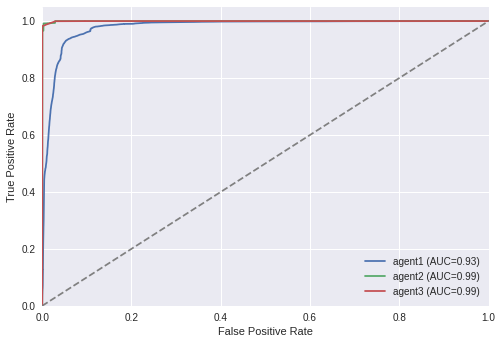

In [15]:
plt.style.use('seaborn')
plt.figure()

index = 0

for model_key, result in results.items():
    fpr, tpr, thresholds = result["fpr"], result["tpr"], result["thresholds"]
    AUC = result["auc"]
    plt.plot(fpr, tpr, label="{} (AUC={:.2f})".format(model_key, AUC))
    index = index + 1
    
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

In [16]:
def process_results(results, remove_list=[]):
    all_values = []
    for major_key in results.keys():
        print(results.keys())
        if (major_key in remove_list) in remove_list:
            continue
        values = []
        for i in range(1, len(agents)+1):
            if ("agent" + str(i)) in remove_list:
                continue
            values.append(results[major_key]["agent" + str(i)])
        all_values.append(values)
    return all_values

In [17]:
localized_results = process_results(results)

dict_keys(['agent1', 'agent2', 'agent3'])
dict_keys(['agent1', 'agent2', 'agent3'])
dict_keys(['agent1', 'agent2', 'agent3'])


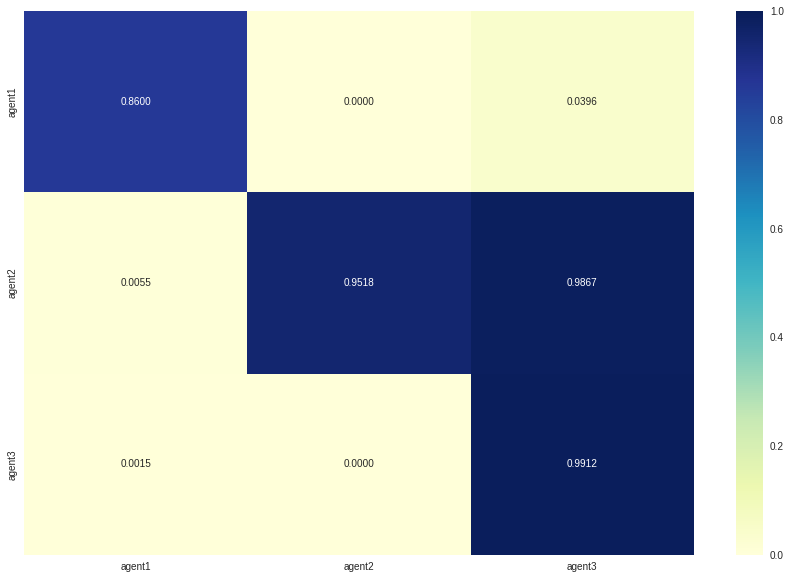

In [18]:
labels = [i for i in agents.keys()]
plt.figure(figsize = (15,10))
ax = sns.heatmap(localized_results, vmin=0, vmax=1, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")

### Global Model

In [19]:
lr = 0.1

fedavg = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0) # global

# initialize global model
features = df_ton_iot_ddos.drop(columns = ["Label"]).shape[1] # total number of features
fedavg.intercept_ = np.zeros(1)
fedavg.coef_ = np.zeros((1, features))
fedavg.classes_ = np.array([0, 1])

### Agent Models

In [20]:
sgd_agents = dict()
for agent in agents.keys():
    sgd_agents[agent] = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)

### Auxiliary Functions

In [21]:
# update each agent model by current global model values
def load_global_model(model):
    model.intercept_ = fedavg.intercept_.copy()
    model.coef_ = fedavg.coef_.copy()
    return model

In [22]:
def update_global_model(applicable_models, round_weights):
    # Average models parameters
    coefs = []
    intercept = []
    for model in applicable_models:
        coefs.append(model.coef_)
        intercept.append(model.intercept_)
    
    # average and update FedAvg (aggregator model)
    fedavg.coef_ = np.average(coefs, axis=0, weights=round_weights) # weight
    fedavg.intercept_ = np.average(intercept, axis=0, weights=round_weights) # weight

In [23]:
def train_local_agent(X, y, model, epochs, class_weight):
    for _ in range(0, epochs):
        model.partial_fit(X, y, classes=np.unique(y), sample_weight=class_weight)
    return model

In [24]:
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

### FedAvg hyperparameters

In [25]:
rounds = 50

# Epochs
# FedAvg requires a minimum number of training epochs before averaging
# For epoch=1 is the same as FedSGD (https://www.cs.cornell.edu/~shmat/shmat_ccs15.pdf)
epochs = 20

# train_size same as batch size
# If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. 
# If int, represents the absolute number of train samples
train_size=100 #0.05

O número de agentes participantes de cada round é aletório. 

In [26]:
balanced = True
def rebalance_agent(agent):
    agent_label_count = agent["Label"].value_counts().to_dict()
    benign_count = agent_label_count[0] 
    malicious_count = agent_label_count[1]
    
    if(balanced):
        if (benign_count > malicious_count):
            downsampled_0 = resample(
                                agent[agent.Label == 0], 
                                replace=False, 
                                n_samples=agent[agent.Label == 1].shape[0],
                                random_state=1337
                            )
            agent_balanced = pd.concat([downsampled_0, agent[agent.Label == 1]])
        elif (benign_count < malicious_count): 
            downsampled_1 = resample(
                                agent[agent.Label == 1], 
                                replace=False, 
                                n_samples=agent[agent.Label == 0].shape[0], 
                                random_state=1337
                            )
            agent_balanced = pd.concat([downsampled_1, agent[agent.Label == 0]])
        else:
            agent_balanced = agent
    else:
        agent_balanced = agent
    
    return agent_balanced

In [27]:
def test_agent_model(clf, agent):
    X = agent.drop(columns = ["Label"])
    y = agent.Label
    X = preprocess(X)
    
    X_train, X_test, _, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
    
    prep = StandardScaler() 
    
    X_train = prep.fit_transform(X_train)
    X_test = prep.transform(X_test) 
    y_pred = clf.predict(X_test)
    
    return f1_score(y_test, y_pred, average="binary")

In [28]:
rounds_f1_score = dict()
# Realização do treinamento federado com os dados rebalanceados
print("Treinamento Federado Iniciado.")
for r in range(rounds):
    # O número de dispostivos participantes do treinamento federado será um número aleatório dentre os dispositivos
    # existentes na lista de agentes.
    sample_size = random.randint(int(len(agents)/2), len(agents))
    applicable_agents = random.sample(list(results.keys()), k=sample_size) # select random agents/silos

    applicable_models = []
    applicable_name = []

    # for calculating weighted average
    round_weights = []
    dataset_size = 0
    
    for name, agent in agents.items():
        
        if name not in applicable_agents: # check if agent/silos is in applicable_agents
            continue
            
        applicable_name.append(name)
        
        print(".", end=" ")
        agent_balanced = rebalance_agent(agent)
        
        X = agent_balanced.drop(columns = ["Label"])
        y = agent_balanced.Label

        X = preprocess(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=train_size, stratify=y) #stratified / random_state=seed
        X_train = prep.fit_transform(X_train)

        dataset_size += X_train.shape[0]

        sample_weights = compute_sample_weight('balanced', y=y_train)
        sgd_agents[name] = load_global_model(sgd_agents[name])
        sgd_agents[name] = train_local_agent(X_train, y_train, sgd_agents[name], epochs, sample_weights)
        round_weights.append(X_train.shape[0])
        applicable_models.append(sgd_agents[name])

    # Update global model (FedAvg) after each round
    round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size

    try:
        update_global_model(applicable_models, round_weights)
    except:
        print("Erro ao atualizar o modelo global, devido a divisão por 0")
       
    # Envia o modelo treinado para os agentes e avalia o f1-score por round
    for name, agent in agents.items():
        sgd_agents[name] = load_global_model(sgd_agents[name])
        if(not name in rounds_f1_score):
            rounds_f1_score[name] = list()
        rounds_f1_score[name].append(test_agent_model(sgd_agents[name], agent))

Treinamento Federado Iniciado.
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Exibição da evolução da métrica de treinamento F1-Score por rounds

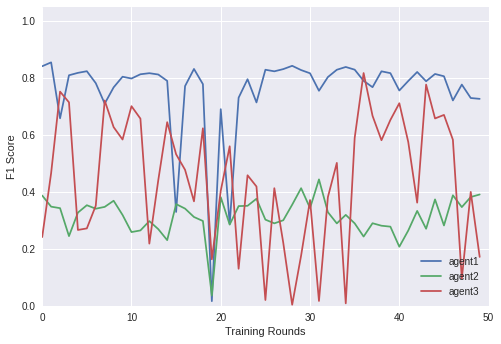

In [29]:
index = 0 
plt.style.use('seaborn')
plt.figure()

for name, metric in rounds_f1_score.items():
    rounds_list = [i for i in range(len(metric))]
    plt.plot(rounds_list, metric, label="{}".format(name))
    index = index + 1
    
plt.xlim([0.0, 50.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Training Rounds')
plt.ylabel('F1 Score')
plt.legend(loc="lower right")

In [28]:
rounds_f1_score = dict()
# Realização do treinamento federado com os dados rebalanceados
print("Treinamento Federado Iniciado.")
for r in range(rounds):
    # O número de dispostivos participantes do treinamento federado será um número aleatório dentre os dispositivos
    # existentes na lista de agentes.
    sample_size = len(agents)
    applicable_agents = random.sample(list(results.keys()), k=sample_size) # select random agents/silos

    applicable_models = []
    applicable_name = []

    # for calculating weighted average
    round_weights = []
    dataset_size = 0
    
    for name, agent in agents.items():
        
        if name not in applicable_agents: # check if agent/silos is in applicable_agents
            continue
            
        applicable_name.append(name)
        
        print(".", end=" ")
        agent_balanced = rebalance_agent(agent)
        
        X = agent_balanced.drop(columns = ["Label"])
        y = agent_balanced.Label

        X = preprocess(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=train_size, stratify=y) #stratified / random_state=seed
        X_train = prep.fit_transform(X_train)

        dataset_size += X_train.shape[0]

        sample_weights = compute_sample_weight('balanced', y=y_train)
        sgd_agents[name] = load_global_model(sgd_agents[name])
        sgd_agents[name] = train_local_agent(X_train, y_train, sgd_agents[name], epochs, sample_weights)
        round_weights.append(X_train.shape[0])
        applicable_models.append(sgd_agents[name])

    # Update global model (FedAvg) after each round
    round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size

    try:
        update_global_model(applicable_models, round_weights)
    except:
        print("Erro ao atualizar o modelo global, devido a divisão por 0")
       
    # Envia o modelo treinado para os agentes e avalia o f1-score por round
    for name, agent in agents.items():
        sgd_agents[name] = load_global_model(sgd_agents[name])
        if(not name in rounds_f1_score):
            rounds_f1_score[name] = list()
        rounds_f1_score[name].append(test_agent_model(sgd_agents[name], agent))

Treinamento Federado Iniciado.
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Exibição da evolução da métrica de treinamento F1-Score por rounds

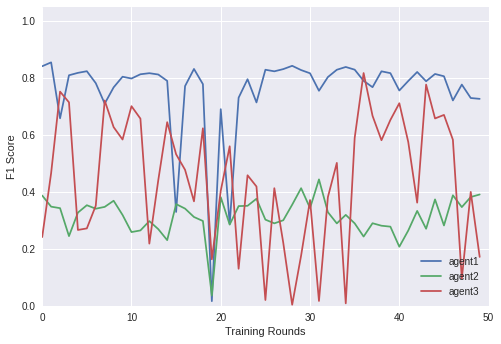

In [29]:
index = 0 
plt.style.use('seaborn')
plt.figure()

for name, metric in rounds_f1_score.items():
    rounds_list = [i for i in range(len(metric))]
    plt.plot(rounds_list, metric, label="{}".format(name))
    index = index + 1
    
plt.xlim([0.0, 50.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Training Rounds')
plt.ylabel('F1 Score')
plt.legend(loc="lower right")

In [30]:
cross_validation_over_samples = dict()

print("Cross Validation Analisys Started...")
for name, agent in agents.items():
    
    print(".", end="")
        
    X = agent.drop(columns = ["Label"])
    y = agent.Label

    # X, y = oversample.fit_resample(X_imbalanced, y_imbalanced)

    X = preprocess(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
    
    X_train = prep.fit_transform(X_train)
    X_test = prep.transform(X_test) 
    
    y_pred = sgd_agents[name].predict(X_test)
    
    cross_validation_over_samples[name] = dict()
    cross_validation_over_samples[name][name] = f1_score(y_test, y_pred, average="binary")
    
    print(name + " " + str(cross_validation_over_samples[name][name]))
    for test_name, test_agent in agents.items():
        if test_name == name:
            continue
        
        X = test_agent.drop(columns = ["Label"])
        y = test_agent.Label
        X = preprocess(X)
        X = prep.transform(X)
        
        y_pred = sgd_agents[name].predict(X)
        cross_validation_over_samples[name][test_name] = f1_score(y, y_pred, average="binary")

Cross Validation Analisys Started...
.agent1 0.726785014717955
.agent2 0.3909085583738504
.agent3 0.17171226769074022


In [31]:
over_sampling_results = process_results(cross_validation_over_samples)

dict_keys(['agent1', 'agent2', 'agent3'])
dict_keys(['agent1', 'agent2', 'agent3'])
dict_keys(['agent1', 'agent2', 'agent3'])


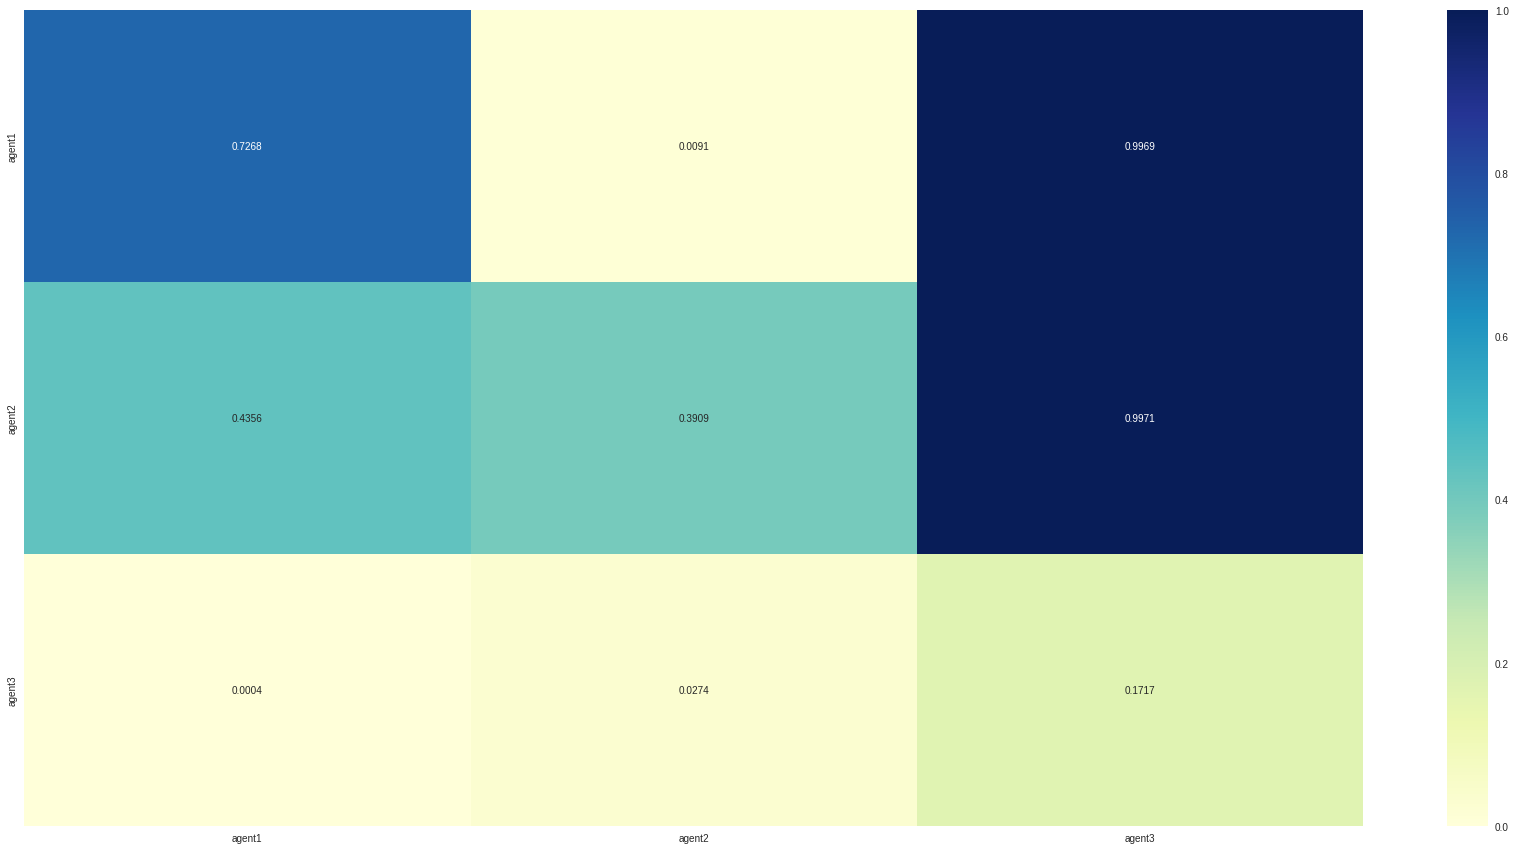

In [32]:
labels = [i for i in agents.keys()]
plt.figure(figsize = (30,15))
ax = sns.heatmap(over_sampling_results, vmin=0, vmax=1, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")

In [33]:
del agent
del agent_balanced
del test_agent
gc.collect()

5089

In [34]:
%whos DataFrame

Variable          Type         Data/Info
----------------------------------------
df_bot_iot_ddos   DataFrame              Unnamed: 0  IN_<...>466884 rows x 39 columns]
df_cic_ids_ddos   DataFrame              Unnamed: 0  IN_<...>025837 rows x 39 columns]
df_ton_iot_ddos   DataFrame             Unnamed: 0  IN_B<...>125703 rows x 39 columns]
